In [72]:
import numpy as np 
from utils import *
from haar_like_features import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve
from skimage import io
from skimage.color import rgb2gray
from skimage.transform import resize
import matplotlib.pyplot as plt
import pickle
import os
import time
import cv2
from skimage.util import img_as_int, view_as_windows
from sklearn.ensemble import AdaBoostClassifier as SklearnAdaBoost

utils = Utils()
haar = HaarLikeFeatures()

%matplotlib inline
%reload_ext autoreload
%autoreload 2

## Extract Labels


In [24]:
features_values = utils.load_pickle('../dataset/features_values.pkl')
features_selected_index = utils.load_pickle('../dataset/feat_index_lg_percentile.pkl')
features_selected_values = utils.load_pickle('../dataset/features_values_selected.pkl')

features_values = np.array(features_values)
features_selected_values = np.array(features_selected_values)
features_selected_index = np.array(features_selected_index, dtype=int)

## Prepare Data


In [25]:
X_train, y_train = utils.load_pickle('../dataset/train_lg_percentile.pkl')
print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)

X_train shape:  (30626, 607)
y_train shape:  (30626,)


**I replaced validation with testing _need refactor of names_**


In [26]:
X_val, y_val = utils.load_pickle('../dataset/test_dataset.pkl')
X_val, y_val = X_val[:, features_selected_index], y_val
print('X_val shape: ', X_val.shape)
print('y_val shape: ', y_val.shape)

X_val shape:  (24045, 607)
y_val shape:  (24045,)


In [27]:
X_test, y_test = utils.load_pickle('../dataset/val_dataset.pkl')
X_test = X_test[:, features_selected_index]
print('X_test shape: ', X_test.shape)
print('y_test shape: ', y_test.shape)

X_test shape:  (698, 607)
y_test shape:  (698,)


### Prepare image for testing


In [28]:
img = io.imread('../images/solvay-conference.jpg')
img_gray = img_as_int(rgb2gray(img))

In [29]:
img_windows = view_as_windows(img_gray, (18, 18))
img_windows.shape

(789, 1583, 18, 18)

In [30]:
np.sum(y_train == 1), np.sum(y_train == 0)

(15662, 14964)

## Train


In [31]:
def train_viola_classifier(X, y, T=10, save_path='../models/viola/viola.pkl'):
    P = X[y == 1].copy()
    N = X[y == 0].copy()
    n_samples = X.shape[0]
    n_P = P.shape[0]
    n_N = N.shape[0]
    # 1) Initialize & Normalize weights
    w = np.ones(X.shape[0])
    # all positive are equally weighted same for negative
    w[y == 1] = 1 / (2 * n_P)
    w[y == 0] = 1 / (2 * n_N)

    # ============ Start Training ============
    best_weak_classifiers = []
    alphas = []
    for t in range(T):
        # 2)Normalize weights
        w = w / np.sum(w)
        # ============ Select best weak classifier ============
        weak_classifiers_theta = []
        weak_classifiers_polarity = []
        for feat in range(X.shape[1]):
            # sort weights using feature value
            feature_values = X[:, feat]
            sorted_idx = np.argsort(feature_values)

            sorted_w = w[sorted_idx]
            sorted_y = y[sorted_idx]
            sorted_feature_values = feature_values[sorted_idx]
            # compute Error
            # err = min(S+ + T- - S-, S- + T+ - S+)
            # S seen weights so far
            # T total weights 
            # theta = min feature value => that cause minumum error
            # polarity = 1 if number of postive samples left > number of negative sample else -1
            total_weights_pos = np.sum(sorted_w[sorted_y == 1]) # T+
            total_weights_neg = np.sum(sorted_w[sorted_y == 0]) # T-
            seen_pos_w = sorted_w.copy()
            seen_neg_w = sorted_w.copy()
            seen_pos_w[sorted_y == 0] = 0
            seen_neg_w[sorted_y == 1] = 0

            seen_pos_w = np.cumsum(seen_pos_w) # S+ at each sample
            seen_neg_w = np.cumsum(seen_neg_w) # S- at each sample
            # get count of positive and negative samples at earch step for polarity computation
            cnt_pos_samples = np.ones_like(seen_pos_w)
            cnt_neg_samples = np.ones_like(seen_pos_w)

            cnt_pos_samples[sorted_y == 0] = 0
            cnt_neg_samples[sorted_y == 1] = 0

            cnt_pos_samples = np.cumsum(cnt_pos_samples)
            cnt_neg_samples = np.cumsum(cnt_neg_samples)

            error = np.minimum( seen_pos_w + total_weights_neg - seen_neg_w, 
                            seen_neg_w + total_weights_pos - seen_pos_w)
            min_error_idx = np.argmin(error)
            
            theta = sorted_feature_values[min_error_idx]
            polarity = 1 if cnt_pos_samples[min_error_idx] > cnt_neg_samples[min_error_idx] else -1
            # polarity = 1 if S+ > S- else -1

            weak_classifiers_theta.append(theta)
            weak_classifiers_polarity.append(polarity)
        
        # 3) selected best weak classifier **aka** best feature
        # 3.1) compute prediction of each weak classifier (feature*Polarity < theta*polarity) true if face else false
        polarity = np.array(weak_classifiers_polarity).reshape(1, -1)
        theta = np.array(weak_classifiers_theta).reshape(1, -1)
        lhs = polarity * X
        rhs = polarity * theta  
        rhs = (rhs * np.ones((X.shape[0], 1))) # broadcast theta to all samples
        Y_pred = lhs <= rhs
        Y_pred[Y_pred == True] = 1
        Y_pred[Y_pred == False] = 0

        # 4) compute error
        ww = w.reshape(-1, 1) # broadcast weights (N, 1)
        yy = y.reshape(-1, 1) * np.ones_like(X) # broadcast labels (N, features)
        weight_error = ww * (yy != Y_pred) # get weights of misclassified samples for each feature
        error = np.sum(weight_error, axis=0)
        error /= 19*19
        min_error_idx = np.argmin(error)
        min_error = error[min_error_idx]
        # 5) update weights
        beta = min_error / (1 - min_error)
        alpha = np.log(1/beta + 1e-10)
        prediciation_bst_clf = Y_pred[:, min_error_idx]
        w = w * np.power(beta, 1 - prediciation_bst_clf)
        
        # 6) save best weak classifier
        print("is face: ", np.sum(Y_pred[:, min_error_idx] == 1))
        print("is not face: ", np.sum(Y_pred[:, min_error_idx] == 0))
        best_weak_classifiers.append((min_error_idx, polarity[0, min_error_idx], theta[0, min_error_idx]))
        alphas.append(alpha)

        print(f'Iteration {t+1} - Choosen Feature {min_error_idx} - Error: {min_error} - Beta: {beta} - Alpha: {alpha}')
        # 7) save model
        utils.save_pickle((best_weak_classifiers, alphas), f'{save_path}')
    return best_weak_classifiers, alphas

In [32]:
def train_viola_classifier_dt(X, y, T=10, save_path='../models/viola/viola.pkl'):
    P = X[y == 1].copy()
    N = X[y == 0].copy()
    n_samples = X.shape[0]
    n_P = P.shape[0]
    n_N = N.shape[0]
    # 1) Initialize & Normalize weights
    weights = np.ones(X.shape[0])
    # all positive are equally weighted same for negative
    weights[y == 1] = 1 / (2 * n_P)
    weights[y == 0] = 1 / (2 * n_N)

    # ============ Start Training ============
    best_weak_classifiers = []
    alphas = []
    for t in range(T):
        # 2)Normalize weights
        weights = weights / np.sum(weights)
        total_weights_pos = np.sum(weights[y == 1]) # T+
        total_weights_neg = np.sum(weights[y == 0]) # T-
        # ============ Select best weak classifier ============
        weak_classifiers_theta = []
        weak_classifiers_polarity = []
        weak_classifiers_feature = []

        for index in range(X.shape[1]):
            # sort weights using feature value
            feature_values = X[:, index]
            applied_feature = sorted(zip(weights, feature_values, y), key=lambda x: x[1])

            seen_positive, seen_negative = 0, 0
            positive_weights, negative_weights = 0, 0
            minimum_error, best_feature, best_threshold, best_polarity = float('inf'), None, None, None

            for w, f, label in applied_feature:
                error = min(negative_weights + total_weights_pos - positive_weights,
                            positive_weights + total_weights_neg - negative_weights)

                if error < minimum_error:
                    minimum_error = error
                    best_feature = index
                    best_threshold = f
                    best_polarity = 1 if seen_positive > seen_negative else -1

                if label == 1:
                    seen_positive += 1
                    positive_weights += w
                else:
                    seen_negative += 1
                    negative_weights += w
            weak_classifiers_theta.append(best_threshold)
            weak_classifiers_polarity.append(best_polarity)
            weak_classifiers_feature.append(best_feature)


        best_classifier, best_error, best_accuracy = None, float('inf'), None
        for the, p, f in zip(weak_classifiers_theta, weak_classifiers_polarity, weak_classifiers_feature):
            error, accuracy = 0, []
            for idx in range(y.shape[0]):
                print(w.shape)
                label = y[idx]
                w = weights[idx]
                val = X[idx, f]
                classify = 1 if p * val < p * the else 0
                correctness = np.abs(classify - label)
                accuracy.append(correctness)
                error += w * correctness
                
            error = error / (19*19)
            
            if error < best_error:
                best_classifier, best_error, best_accuracy = (the, p, f), error, accuracy

        classifier, error, accuracy = best_classifier, best_error, best_accuracy
    
        beta = error / (1.0 - error)
        for i in range(len(accuracy)):
            weights[i] = weights[i] * np.pow(beta, 1 - accuracy[i])

        alpha = np.log(1.0 / (beta + 1e-18))
        alphas.append(alpha)
        best_weak_classifiers.append(classifier)
    
        print(f'Iteration {t+1} - Choosen Feature {classifier[3]} - Error: {error} - Beta: {beta} - Alpha: {alpha}')


    return best_weak_classifiers, alphas


In [33]:
def eval_viola(X, y, classifiers, alphas, threshold=0.5):
    features_index, polarity, theta = zip(*classifiers)
    polarity = np.array(polarity)
    theta = np.array(theta)
    alphas = np.array(alphas)

    X = X[:, features_index]

    lhs = polarity * X
    rhs = polarity * theta  
    rhs = (rhs * np.ones((X.shape[0], 1))) # broadcast theta to all samples
    print("X.shape: ", X.shape)
    print("lhs.shape: ", lhs.shape)
    print("rhs.shape: ", rhs.shape)
    Y_pred = (lhs <= rhs)
    Y_pred = Y_pred.astype(int)

    Y_pred = Y_pred * alphas
    Y_pred = np.sum(Y_pred, axis=1)

    rhss = np.sum(alphas)
    rhss = np.ones((X.shape[0], 1)) * rhss
    Y_pred = Y_pred.reshape(-1, 1)
    Y_pred = Y_pred >= threshold * rhss
    print('Accuracy: ', accuracy_score(y, Y_pred))
    print('Confusion Matrix: ', confusion_matrix(y, Y_pred))
    print('roc_curve: ', roc_curve(y, Y_pred))
    
    return Y_pred

In [34]:
eval_viola(Xt, yt, clf, alphas, threshold=0.5)

NameError: name 'clf' is not defined

In [343]:
y_val.shape

(24045,)

In [344]:
Xt, Xv, yt, yv = train_test_split(X_train, y_train, test_size=0.4, random_state=42)
print('Xt shape: ', Xt.shape)
print('yt shape: ', yt.shape)
print('Xv shape: ', Xv.shape)
print('yv shape: ', yv.shape)
clf, alphas = train_viola_classifier_dt(Xt, yt, 10)


Xt shape:  (18375, 4246)
yt shape:  (18375,)
Xv shape:  (12251, 4246)
yv shape:  (12251,)


In [35]:
def classify_viola(image, classifiers, alphas, threshold=0.5):
    features_index, polarity, theta = zip(*classifiers)
    polarity = np.array(polarity)
    theta = np.array(theta)
    alphas = np.array(alphas)
    theta = np.array(theta)

    features = [features_selected_values[i] for i in features_index]
    feature_values = haar.get_feautures_result(image, features)
    weak_pred = feature_values * polarity <= theta * polarity
    weak_pred = weak_pred.astype(int)
    
    total_vote = np.sum(weak_pred * alphas)
    return 1 if total_vote >= (threshold*np.sum(alphas) )else 0

In [36]:
img_windows.shape

(789, 1583, 18, 18)

## Train Casscade


In [60]:
def train_cascade(X, y, layers = [10, 10, 10]):
    faces, non_faces = X[y == 1], X[y == 0]
    clfs = []
    for i in layers:
        if non_faces.shape[0] == 0:
            print("===== Training Done =====")
            break
        training = np.concatenate((faces, non_faces))
        training_labels = np.concatenate((np.ones(faces.shape[0]), np.zeros(non_faces.shape[0])))
        clf, alphas = train_viola_classifier(training, training_labels, i, save_path=f'../models/viola/viola_{i}.pkl')
        predictions = eval_viola(training, training_labels, clf, alphas, threshold=0.5)
        print(predictions.shape)
        print(training.shape)
        print(training_labels.shape)
        predictions = predictions.reshape(-1)
        false_postive_idx = (training_labels == 0) & (predictions == 1)
        print(false_postive_idx.shape)
        non_faces = training[false_postive_idx, :]
        clfs.append((clf, alphas))
    return clf

In [97]:
def train_cascade(X, y, layers = [10, 10, 10]):
    faces, non_faces = X[y == 1], X[y == 0]
    clfs = []
    for i in layers:
        if non_faces.shape[0] == 0:
            print("===== Training Done =====")
            break
        training = np.concatenate((faces, non_faces))
        training_labels = np.concatenate((np.ones(faces.shape[0]), np.zeros(non_faces.shape[0])))
        clf = SklearnAdaBoost(n_estimators=i)
        clf.fit(training, training_labels)
        predictions = clf.predict(training)
        print(predictions.shape)
        clfs.append(clf)
    return clfs

In [98]:
X_train.shape

(30626, 607)

In [160]:
cascade_clf = train_cascade(X_train, y_train, layers=[20, 20, 20])

(30626,)
(30626,)
(30626,)


## Testing


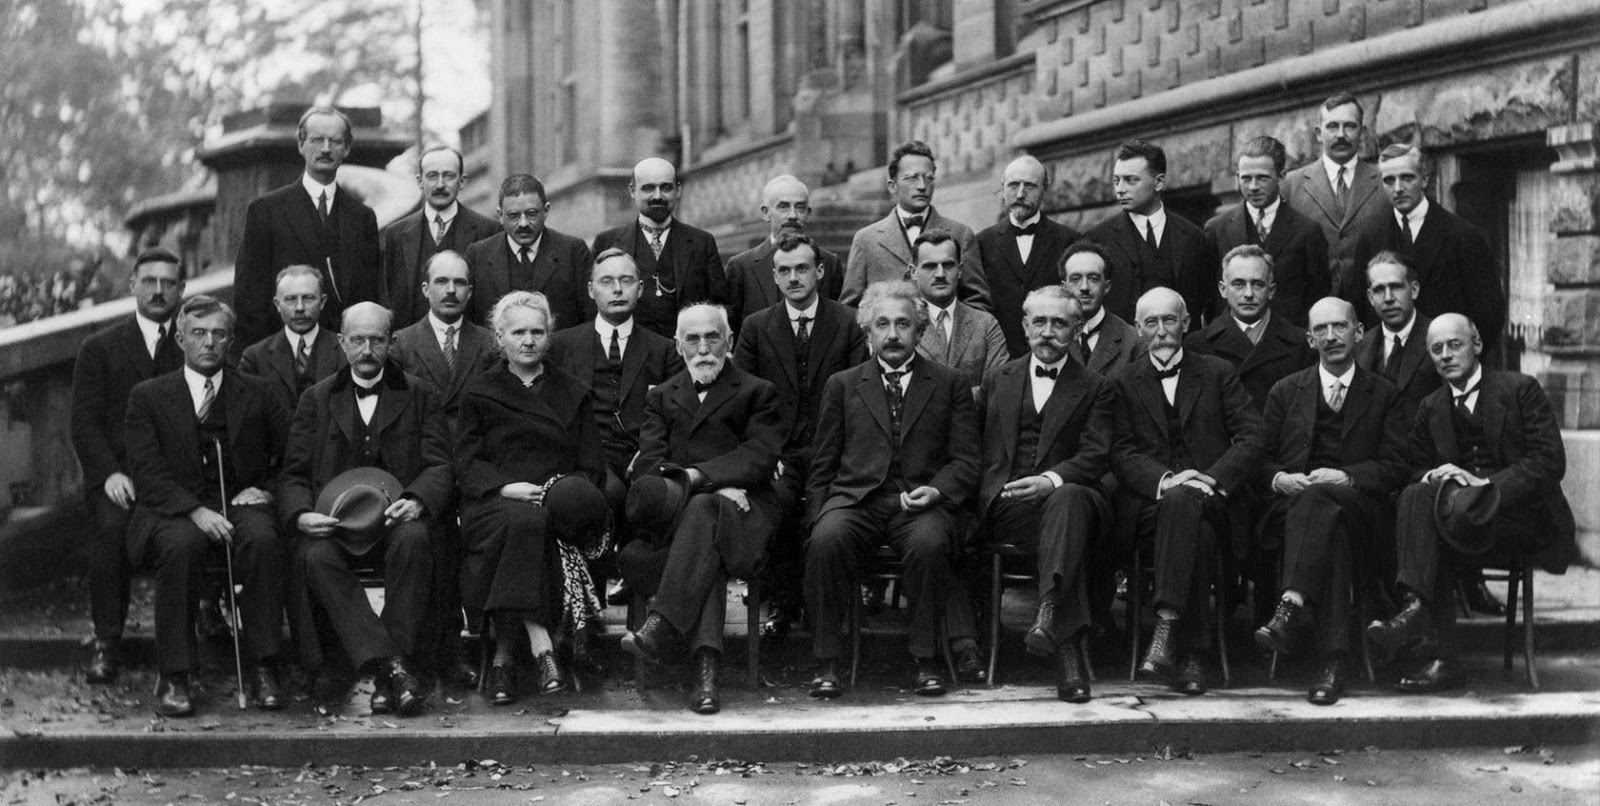

In [164]:
from PIL import Image
img = Image.open('../Images/solvay-conference.jpg')
imgG = img.convert("L")
imgG

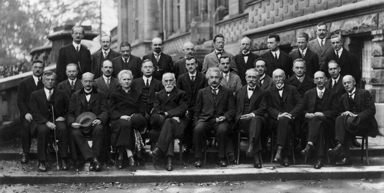

In [165]:
imgP = imgG.copy()
imgP.thumbnail((384, 288),)
img_arr = np.array(imgP)
imgP

0.0
not cool
0.0
not cool
0.0
not cool
0.0
not cool
0.0
not cool
0.0
not cool
0.0
not cool
0.0
not cool
0.0
not cool
0.0
not cool
0.0
not cool
0.0
not cool
0.0
not cool
0.0
not cool
0.0
not cool
0.0
not cool
0.0
not cool
0.0
not cool
0.0
not cool
0.0
not cool
0.0
not cool
0.0
not cool
0.0
not cool
0.0
not cool
0.0
not cool
0.0
not cool
0.0
not cool
0.0
not cool
0.0
not cool
0.0
not cool
0.0
not cool
0.0
not cool
0.0
not cool
0.0
not cool
0.0
not cool
0.0
not cool
0.0
not cool
0.0
not cool
0.0
not cool
0.0
not cool
0.0
not cool
0.0
not cool
0.0
not cool
0.0
not cool
0.0
not cool
0.0
not cool
0.0
not cool
0.0
not cool
0.0
not cool
0.0
not cool
0.0
not cool
0.0
not cool
0.0
not cool
0.0
not cool
0.0
not cool
0.0
not cool
0.0
not cool
0.0
not cool
0.0
not cool
0.0
not cool
0.0
not cool
0.0
not cool
0.0
not cool
0.0
not cool
0.0
not cool
0.0
not cool
0.0
not cool
0.0
not cool
0.0
not cool
0.0
not cool
0.0
not cool
0.0
not cool
0.0
not cool
0.0
not cool
0.0
not cool
0.0
not cool
0.0
not cool

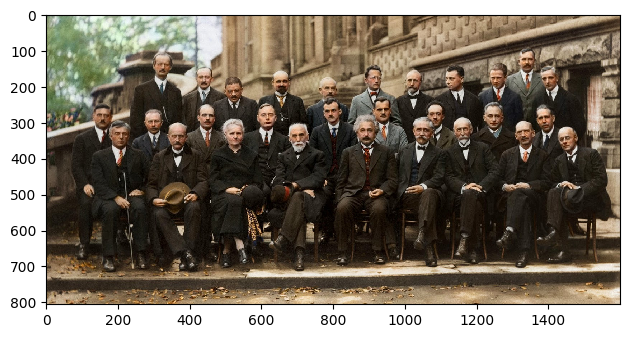

In [169]:
def classify_viola(image, clfs):
    for i in clfs:
        feat_idx = i.feature_importances_ 
        feat_input = np.zeros_like(feat_idx)
        feat_idx = np.where(feat_idx > 0)
        features = features_values[feat_idx]
        features = features.astype(int)
        features_result = haar.get_feautures_result(image, features)

        feat_input[feat_idx] = features_result
        pred = i.predict([feat_input])
        print(pred[0])
        if pred[0] == 0: return False
    return True

img_res = img.copy()
img_res = np.array(img_res)
integral_image = utils.get_integral_image(img_arr).astype(int)
immg 
for i in range(0, img_arr.shape[0]-20, 20):
    for j in range(0, img_arr.shape[1]-20, 20):
        if classify_viola(integral_image[i:i+20, j:j+20], cascade_clf):
            img_res[i:i+20, j] = [255, 0, 0]
            img_res[i:i+20, j+20] = [255, 0, 0]
            img_res[i, j:j+20] = [255, 0, 0]
            img_res[i+20, j:j+20] = [255, 0, 0]
            print("cool")
        else:
            print("not cool")
io.imshow(img_res)
io.show()= X_val[0]

In [ ]:
HaarFeautureTypes(feat[0]),

SyntaxError: leading zeros in decimal integer literals are not permitted; use an 0o prefix for octal integers (3059366561.py, line 1)

In [159]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=20)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=20)